In [112]:
import requests
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from InstructorEmbedding import INSTRUCTOR
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import time

In [113]:
dataFrame = pd.read_csv('focus_dataset.csv')
sentences_1 = dataFrame['Sentece1'].tolist()
sentences_2 = dataFrame['Sentece2'].tolist()
scores = dataFrame['Score'].tolist()

In [114]:
# Model: sentence-transformers/all-mpnet-base-v2 (https://huggingface.co/sentence-transformers/all-mpnet-base-v2)
model_all_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
scores_all_mpnet_base_v2 = []
time_mpnet = []

In [115]:
for i in range (len(sentences_1)):
    sentences = [sentences_1[i], sentences_2[i]]
    start_time = time.time()
    paraphrases = util.paraphrase_mining(model_all_mpnet, sentences)
    time_mpnet.append(time.time() - start_time)
    for paraphrase in paraphrases:
        score, i, j = paraphrase
        scores_all_mpnet_base_v2.append(score)

In [116]:
model_sn_xlm = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')
scores_sn_xlm = []
time_xlm = []

In [117]:
for i in range (len(sentences_1)):
    sentences = [sentences_1[i], sentences_2[i]]
    start_time = time.time()
    paraphrases = util.paraphrase_mining(model_sn_xlm, sentences)
    time_xlm.append(time.time() - start_time)
    for paraphrase in paraphrases:
        score, i, j = paraphrase
        scores_sn_xlm.append(score)

In [118]:
xlDf = pd.read_csv("xl_score.csv")
xlDf = xlDf.drop(columns=["Unnamed: 0"])
xlDf

,instructor_xlScore,time_instructor_xl
0,0.872613,1.577328
1,0.956497,1.861566
2,0.988381,1.830455
3,0.976053,1.645153
4,0.799685,1.719680
...,...,...
837,0.988263,1.862371
838,0.889561,1.583450
839,0.901799,1.672656
840,0.918012,1.633009


In [119]:
eval = pd.DataFrame({'Score': dataFrame['Score']})
eval['Score'] = eval['Score'] / 5
eval = pd.concat([eval, pd.DataFrame({'mpnetScore': scores_all_mpnet_base_v2, 'xlmScore': scores_sn_xlm, 'time_mpnet': time_mpnet, 'time_xlm': time_xlm})], axis=1)
eval = pd.concat([eval, xlDf], axis=1) 
eval

,Score,mpnetScore,xlmScore,time_mpnet,time_xlm,instructor_xlScore,time_instructor_xl
0,0.50,0.751502,0.835926,0.045259,0.049371,0.872613,1.577328
1,0.72,0.802421,0.794322,0.051439,0.049815,0.956497,1.861566
2,1.00,0.970881,0.937484,0.050045,0.054855,0.988381,1.830455
3,0.84,0.899563,0.875401,0.047021,0.055810,0.976053,1.645153
4,0.30,0.396793,0.365940,0.038609,0.045990,0.799685,1.719680
...,...,...,...,...,...,...,...
837,0.80,0.966470,0.962412,0.057785,0.072686,0.988263,1.862371
838,0.80,0.778657,0.734625,0.051311,0.059469,0.889561,1.583450
839,0.55,0.775953,0.667699,0.056011,0.094640,0.901799,1.672656
840,0.45,0.797687,0.829092,0.050252,0.056313,0.918012,1.633009


In [120]:
eval.to_csv("eval.csv")

 # Estadisticas

In [121]:
eval['diff_mpnet'] = eval['mpnetScore'] - eval['Score']
eval['diff_xlm'] = eval['xlmScore'] - eval['Score']
eval['diff_instructor_xl'] = eval['instructor_xlScore'] - eval['Score']

In [122]:
eval[['diff_mpnet', 'diff_xlm', 'diff_instructor_xl']].describe()

,diff_mpnet,diff_xlm,diff_instructor_xl
count,842.000000,842.000000,842.000000
mean,0.074870,0.011392,0.307614
std,0.128440,0.173933,0.193571
min,-0.279184,-0.679057,-0.070663
25%,-0.014192,-0.084244,0.147840
50%,0.069219,0.011058,0.295537
75%,0.156415,0.117324,0.473513
max,0.550217,0.494034,0.735792


## Distibucion del error

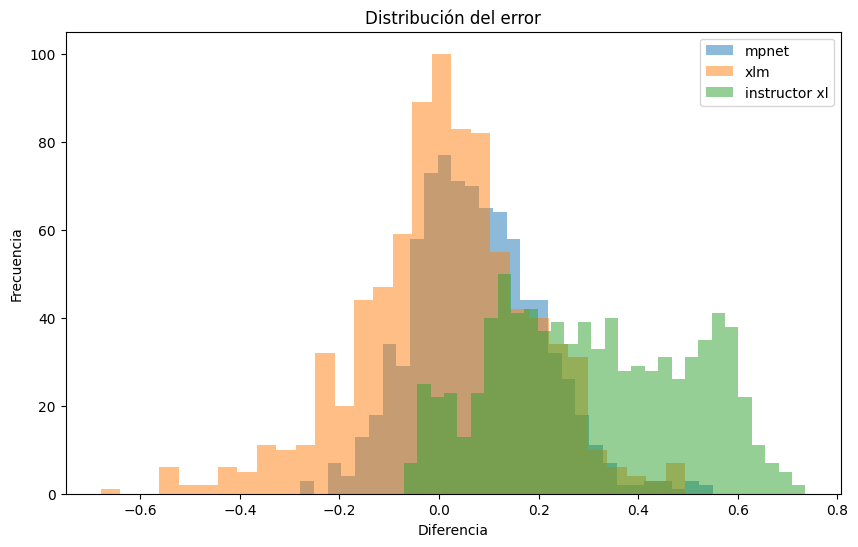

In [123]:
plt.figure(figsize=(10,6))

plt.hist(eval['diff_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.hist(eval['diff_xlm'], bins=30, alpha=0.5, label='xlm')
plt.hist(eval['diff_instructor_xl'], bins=30, alpha=0.5, label='instructor xl')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución del error')
plt.show()

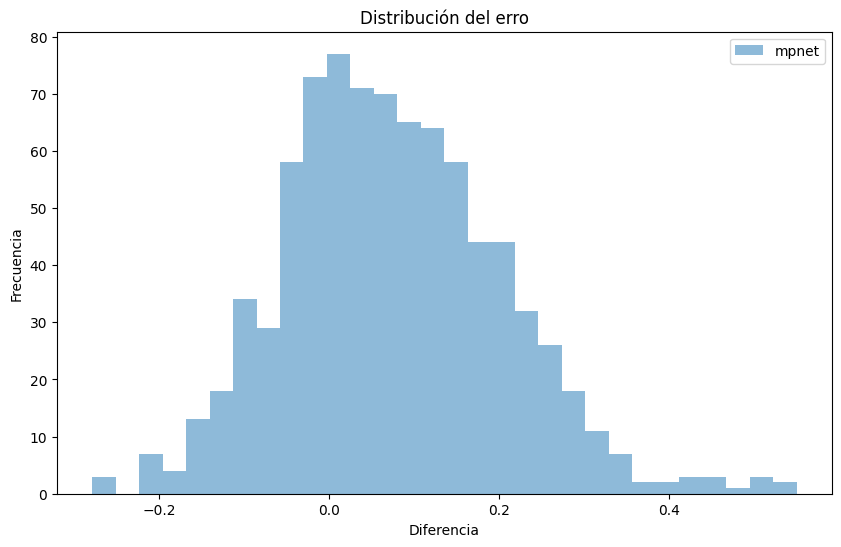

In [124]:
plt.figure(figsize=(10,6))

plt.hist(eval['diff_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución del error')
plt.show()

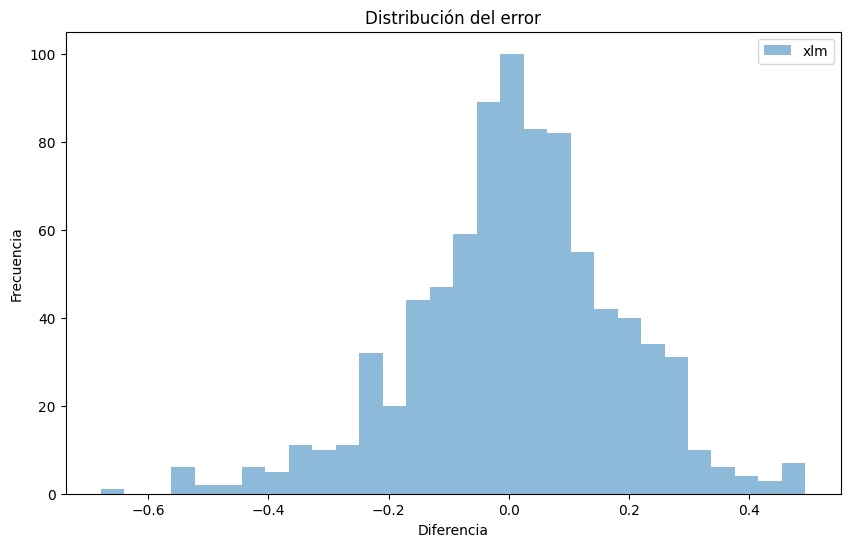

In [125]:
plt.figure(figsize=(10,6))

plt.hist(eval['diff_xlm'], bins=30, alpha=0.5, label='xlm')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución del error')
plt.show()

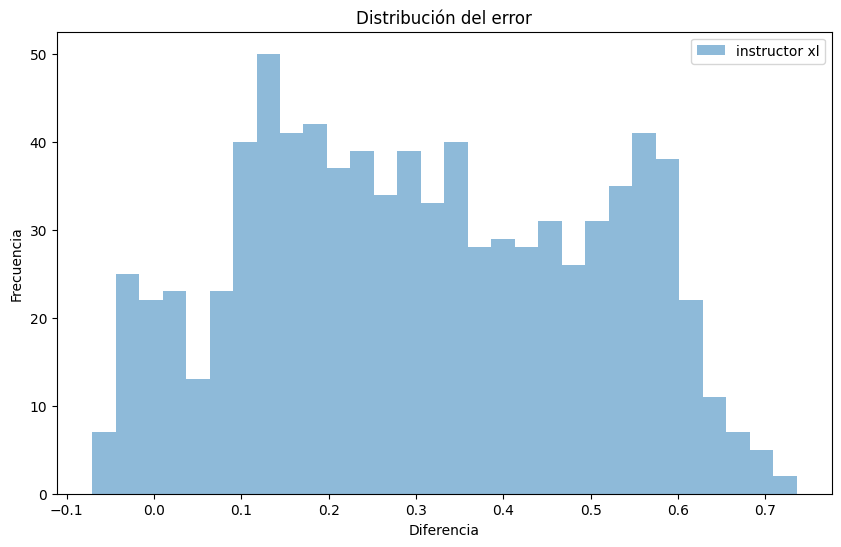

In [126]:
plt.figure(figsize=(10,6))
plt.hist(eval['diff_instructor_xl'], bins=30, alpha=0.5, label='instructor xl')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Distribución del error')
plt.show()

## Matriz de confusion

Considera que una prediccion <.5 es negativa y >= .5 es positiva.

In [127]:
eval['Score_bin'] = (eval['Score'] >= 0.5).astype(int)
eval['mpnetScore_bin'] = (eval['mpnetScore'] >= 0.5).astype(int)
eval['xlmScore_bin'] = (eval['xlmScore'] >= 0.5).astype(int)
eval['instructor_xlScore_bin'] = (eval['instructor_xlScore'] >= 0.5).astype(int)

conf_mat_mpnet = confusion_matrix(eval['Score_bin'], eval['mpnetScore_bin'])
conf_mat_xlm = confusion_matrix(eval['Score_bin'], eval['xlmScore_bin'])
conf_mat_instructor_xl = confusion_matrix(eval['Score_bin'], eval['instructor_xlScore_bin'])

print("Matriz de confusión mpnetScore:\n", conf_mat_mpnet)
print("\nMatriz de confusión xlmScore:\n", conf_mat_xlm)
print("\nMatriz de confusión instructor xl:\n", conf_mat_instructor_xl)

Matriz de confusión mpnetScore:
 [[263  89]
 [ 15 475]]

Matriz de confusión xlmScore:
 [[278  74]
 [ 62 428]]

Matriz de confusión instructor xl:
 [[  1 351]
 [  0 490]]


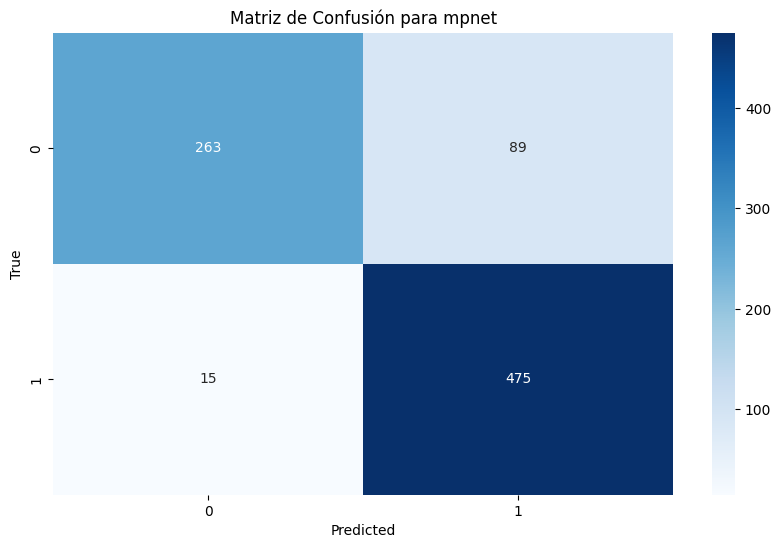

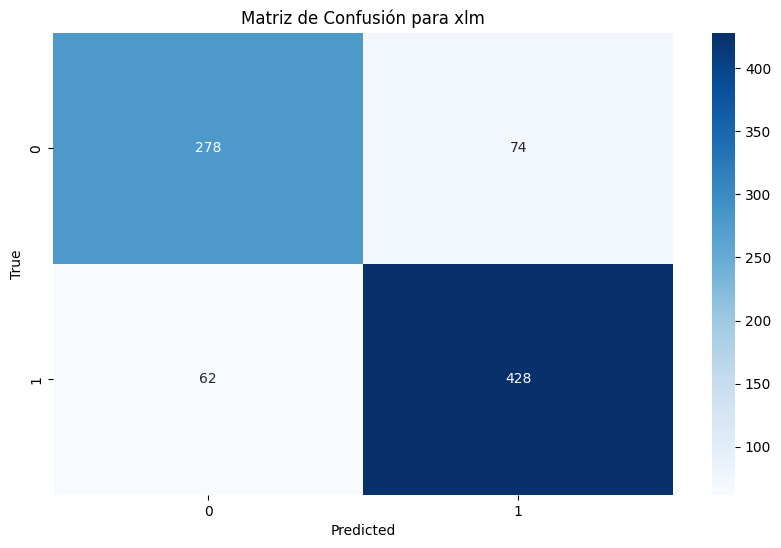

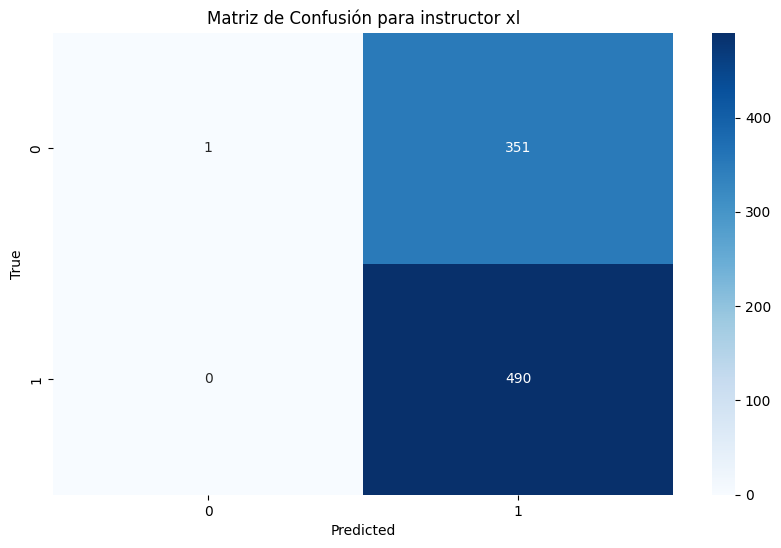

In [128]:
conf_mat_mpnet = confusion_matrix(eval['Score_bin'], eval['mpnetScore_bin'])
conf_mat_xlm = confusion_matrix(eval['Score_bin'], eval['xlmScore_bin'])
conf_mat_instructor_xl = confusion_matrix(eval['Score_bin'], eval['instructor_xlScore_bin'])

plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_mpnet, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión para mpnet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_xlm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión para xlm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(conf_mat_instructor_xl, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión para instructor xl')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Cuartiles
    Hay dos graficas para cada uno, solo por razones esteticas para ver despues cual usamos.
### Predicciones

In [129]:
eval[['mpnetScore', 'xlmScore', 'instructor_xlScore']].describe()

,mpnetScore,xlmScore,instructor_xlScore
count,842.000000,842.000000,842.000000
mean,0.594739,0.531261,0.827484
std,0.279468,0.305573,0.118445
min,-0.113272,-0.192151,0.497574
25%,0.394887,0.269244,0.759924
50%,0.673525,0.599022,0.855717
75%,0.815622,0.786734,0.918550
max,0.995219,0.997219,0.993613


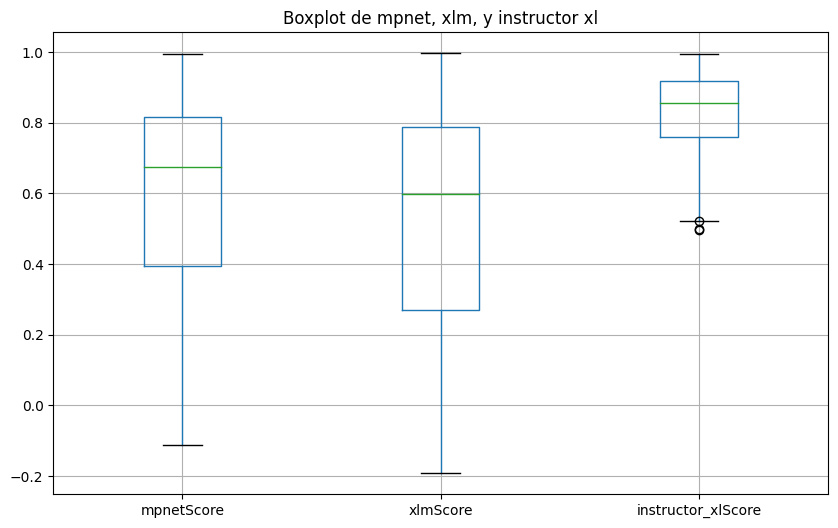

In [130]:
plt.figure(figsize=(10,6))
eval[['mpnetScore', 'xlmScore', 'instructor_xlScore']].boxplot()
plt.title('Boxplot de mpnet, xlm, y instructor xl')
plt.show()


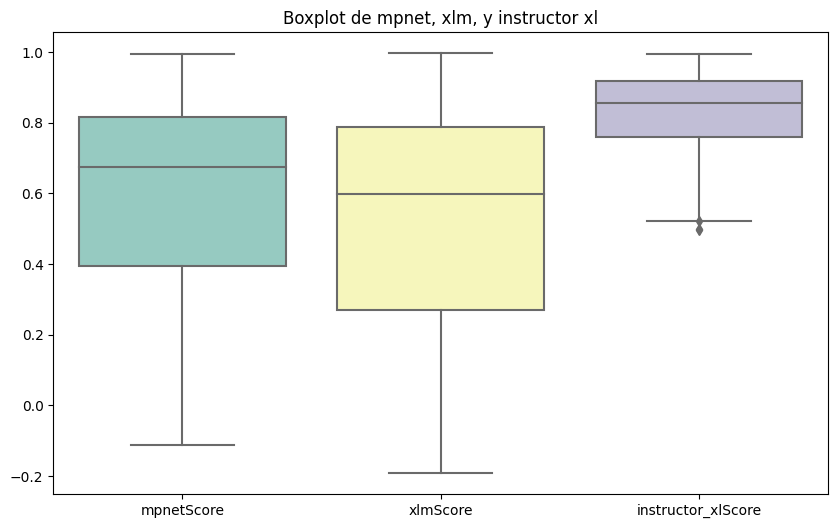

In [131]:
plt.figure(figsize=(10,6))
sns.boxplot(data=eval[['mpnetScore', 'xlmScore','instructor_xlScore']], palette='Set3')
plt.title('Boxplot de mpnet, xlm, y instructor xl')
plt.show()

### Errores

In [132]:
eval[['diff_mpnet', 'diff_xlm', 'diff_instructor_xl']].describe()

,diff_mpnet,diff_xlm,diff_instructor_xl
count,842.000000,842.000000,842.000000
mean,0.074870,0.011392,0.307614
std,0.128440,0.173933,0.193571
min,-0.279184,-0.679057,-0.070663
25%,-0.014192,-0.084244,0.147840
50%,0.069219,0.011058,0.295537
75%,0.156415,0.117324,0.473513
max,0.550217,0.494034,0.735792


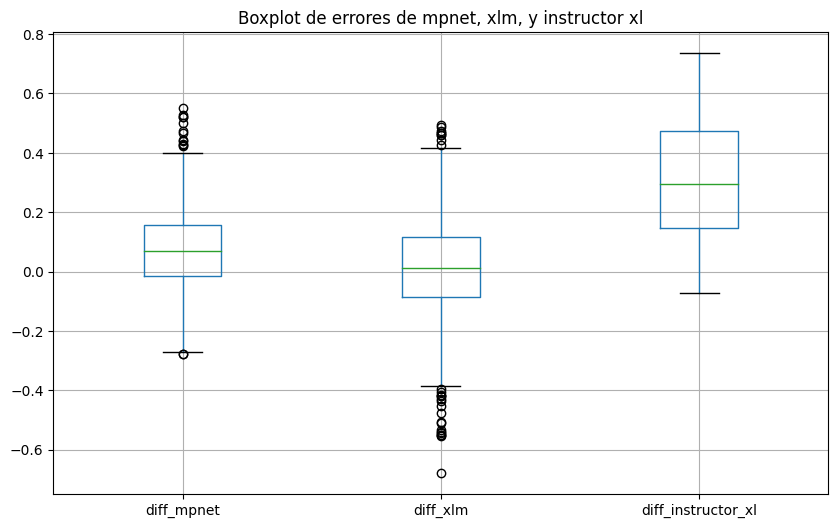

In [133]:
plt.figure(figsize=(10,6))
eval[['diff_mpnet', 'diff_xlm', 'diff_instructor_xl']].boxplot()
plt.title('Boxplot de errores de mpnet, xlm, y instructor xl')
plt.show()

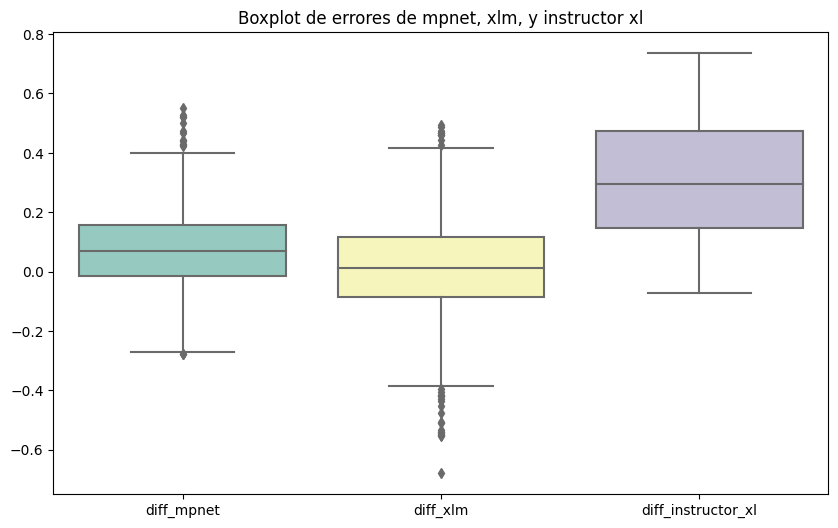

In [134]:
plt.figure(figsize=(10,6))
sns.boxplot(data=eval[['diff_mpnet', 'diff_xlm', 'diff_instructor_xl']], palette='Set3')
plt.title('Boxplot de errores de mpnet, xlm, y instructor xl')
plt.show()

## AUC-ROC

In [135]:
auc_mpnet = roc_auc_score(eval['Score_bin'], eval['mpnetScore_bin'])
auc_xlm = roc_auc_score(eval['Score_bin'], eval['xlmScore_bin'])
auc_xl = roc_auc_score(eval['Score_bin'], eval['instructor_xlScore_bin'])

print("AUC-ROC  mpnet:", auc_mpnet)
print("AUC-ROC  xlm:", auc_xlm)
print("AUC-ROC  instructor xl:", auc_xl)


AUC-ROC  mpnet: 0.8582734230055657
AUC-ROC  xlm: 0.8316210575139147
AUC-ROC  instructor xl: 0.5014204545454546


In [136]:
fpr_mpnet, tpr_mpnet, _ = roc_curve(eval['Score_bin'], eval['mpnetScore_bin'])
fpr_xlm, tpr_xlm, _ = roc_curve(eval['Score_bin'], eval['xlmScore_bin'])
fpr_xl, tpr_xl, _ = roc_curve(eval['Score_bin'], eval['instructor_xlScore_bin'])

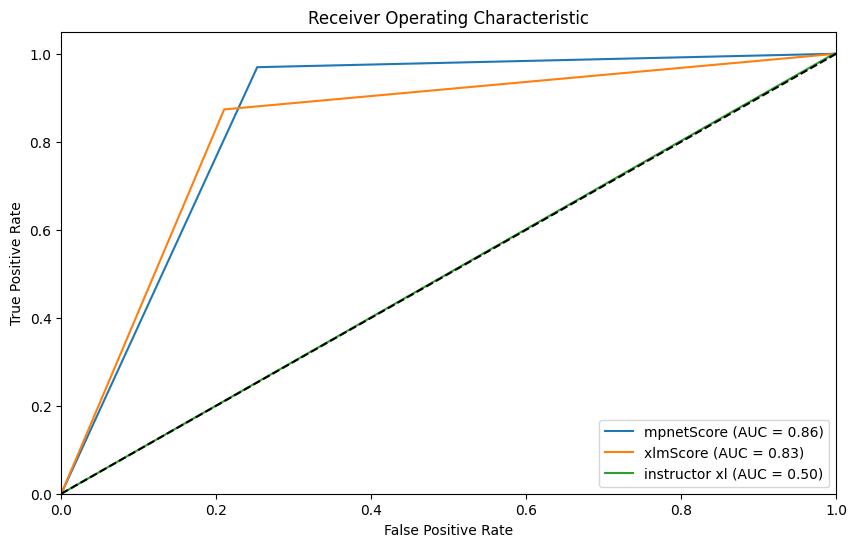

In [137]:
plt.figure(figsize=(10,6))
plt.plot(fpr_mpnet, tpr_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_mpnet)
plt.plot(fpr_xlm, tpr_xlm, label='xlmScore (AUC = %0.2f)' % auc_xlm)
plt.plot(fpr_xl, tpr_xl, label='instructor xl (AUC = %0.2f)' % auc_xl)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

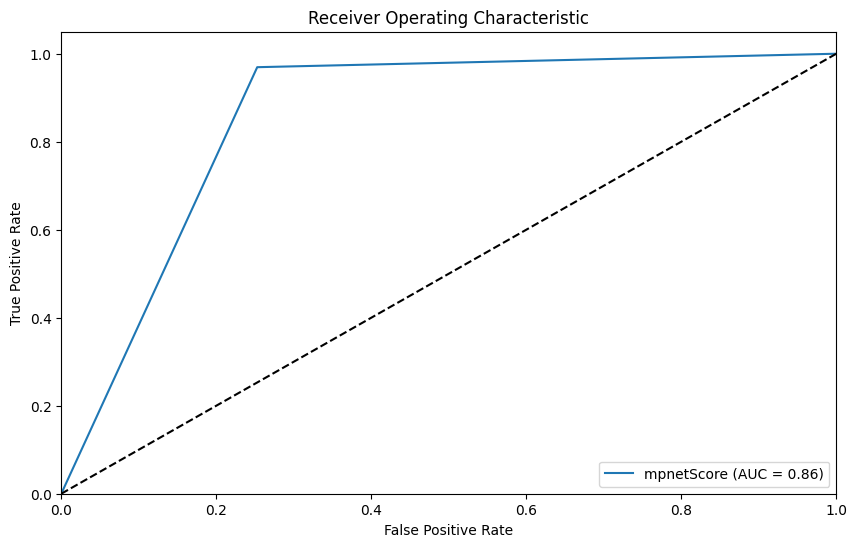

In [138]:
plt.figure(figsize=(10,6))
plt.plot(fpr_mpnet, tpr_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_mpnet)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

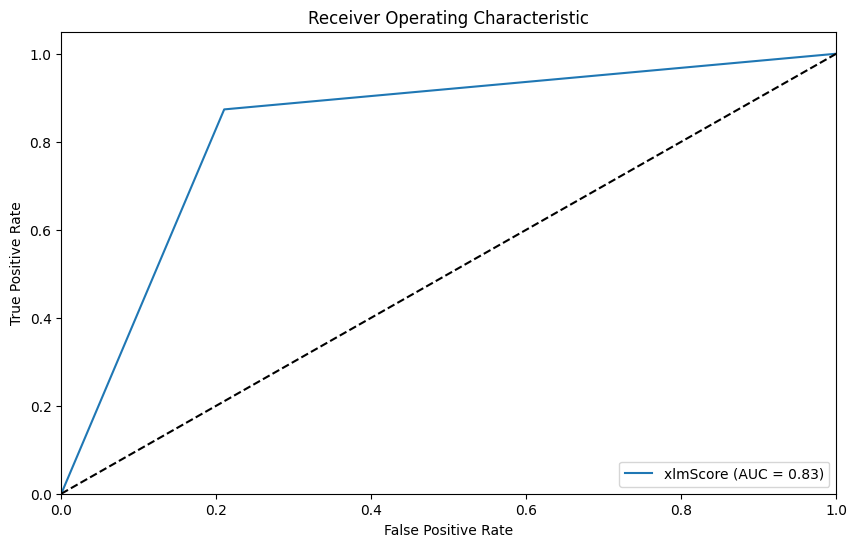

In [139]:
plt.figure(figsize=(10,6))
plt.plot(fpr_xlm, tpr_xlm, label='xlmScore (AUC = %0.2f)' % auc_xlm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


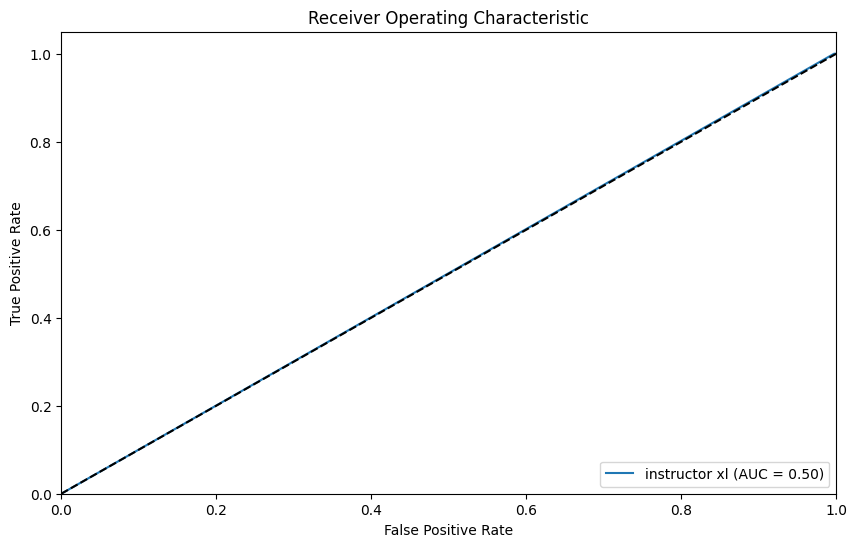

In [140]:
plt.figure(figsize=(10,6))
plt.plot(fpr_xl, tpr_xl, label='instructor xl (AUC = %0.2f)' % auc_xl)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Pearson

In [141]:
pearson_corr_mpnet = eval['Score'].corr(eval['mpnetScore'])
pearson_corr_xlm = eval['Score'].corr(eval['xlmScore'])
pearson_corr_xl = eval['Score'].corr(eval['instructor_xlScore'])

print("Coeficiente de correlación de Pearson mpnetScore:", pearson_corr_mpnet)
print("Coeficiente de correlación de Pearson xlmScore:", pearson_corr_xlm)
print("Coeficiente de correlación de Pearson instructor xl:", pearson_corr_xl)


Coeficiente de correlación de Pearson mpnetScore: 0.899841588647292
Coeficiente de correlación de Pearson xlmScore: 0.8314695225163526
Coeficiente de correlación de Pearson instructor xl: 0.893298949502104


# Metricas de regresion
    MAE, MSE, RMSE, coeficiente de determinacion R²

In [142]:
# MAE
mae_mpnet = mean_absolute_error(eval['Score'], eval['mpnetScore'])
mae_xlm = mean_absolute_error(eval['Score'], eval['xlmScore'])
mae_xl = mean_absolute_error(eval['Score'], eval['instructor_xlScore'])

# MSE
mse_mpnet = mean_squared_error(eval['Score'], eval['mpnetScore'])
mse_xlm = mean_squared_error(eval['Score'], eval['xlmScore'])
mse_xl = mean_squared_error(eval['Score'], eval['instructor_xlScore'])

# RMSE
rmse_mpnet = sqrt(mse_mpnet)
rmse_xlm = sqrt(mse_xlm)
rmse_xl = sqrt(mse_xl)

# Coeficiente de Determinación R²
r2_mpnet = r2_score(eval['Score'], eval['mpnetScore'])
r2_xlm = r2_score(eval['Score'], eval['xlmScore'])
r2_xl = r2_score(eval['Score'], eval['instructor_xlScore'])


In [143]:
print("mpnet:")
print("MAE:", mae_mpnet)
print("MSE:", mse_mpnet)
print("RMSE:", rmse_mpnet)
print("R²:", r2_mpnet)

mpnet:
MAE: 0.11466200284768613
MSE: 0.022082637102767883
RMSE: 0.14860227825564412
R²: 0.740545919185878


In [144]:
print("xlm:")
print("MAE:", mae_xlm)
print("MSE:", mse_xlm)
print("RMSE:", rmse_xlm)
print("R²:", r2_xlm)

xlm:
MAE: 0.13241562085544553
MSE: 0.030346506136789412
RMSE: 0.17420248602356228
R²: 0.6434517843589466


In [145]:
print("xl:")
print("MAE:", mae_xl)
print("MSE:", mse_xl)
print("RMSE:", rmse_xl)
print("R²:", r2_xl)

xl:
MAE: 0.31051150781472686
MSE: 0.13205158088664726
RMSE: 0.3633890214173335
R²: -0.5515049846425437


## Precision-recall

In [146]:
precision_mpnet, recall_mpnet, _ = precision_recall_curve(eval['Score_bin'], eval['mpnetScore_bin'])
precision_xlm, recall_xlm, _ = precision_recall_curve(eval['Score_bin'], eval['xlmScore_bin'])
precision_xl, recall_xl, _ = precision_recall_curve(eval['Score_bin'], eval['instructor_xlScore_bin'])

auc_pr_mpnet = auc(recall_mpnet, precision_mpnet)
auc_pr_xlm = auc(recall_xlm, precision_xlm)
auc_pr_xl = auc(recall_xl, precision_xl)

print("AUC para la curva Precision-Recall mpnet:", auc_pr_mpnet)
print("AUC para la curva Precision-Recall xlm:", auc_pr_xlm)
print("AUC para la curva Precision-Recall instructor xl:", auc_pr_xl)


AUC para la curva Precision-Recall mpnet: 0.9147005317515897
AUC para la curva Precision-Recall xlm: 0.8998466167324498
AUC para la curva Precision-Recall instructor xl: 0.7913198573127229


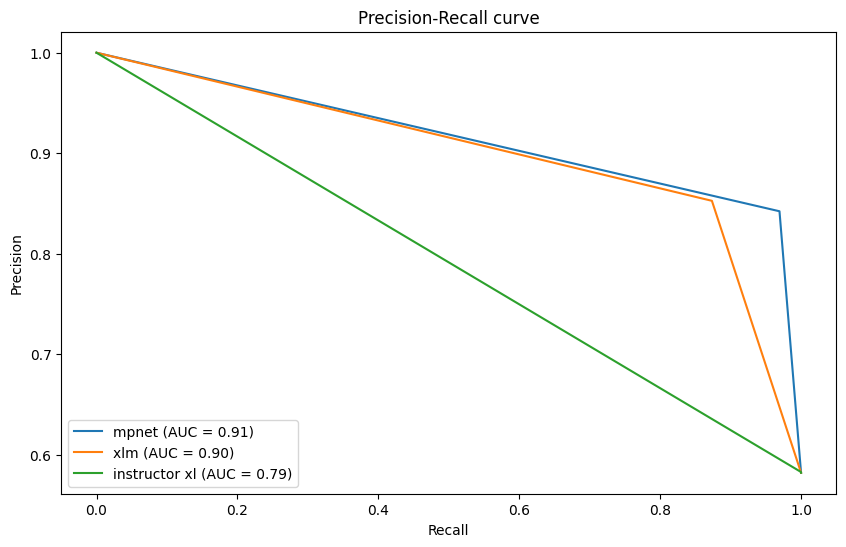

In [147]:
plt.figure(figsize=(10,6))
plt.plot(recall_mpnet, precision_mpnet, label='mpnet (AUC = %0.2f)' % auc_pr_mpnet)
plt.plot(recall_xlm, precision_xlm, label='xlm (AUC = %0.2f)' % auc_pr_xlm)
plt.plot(recall_xl, precision_xl, label='instructor xl (AUC = %0.2f)' % auc_pr_xl)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

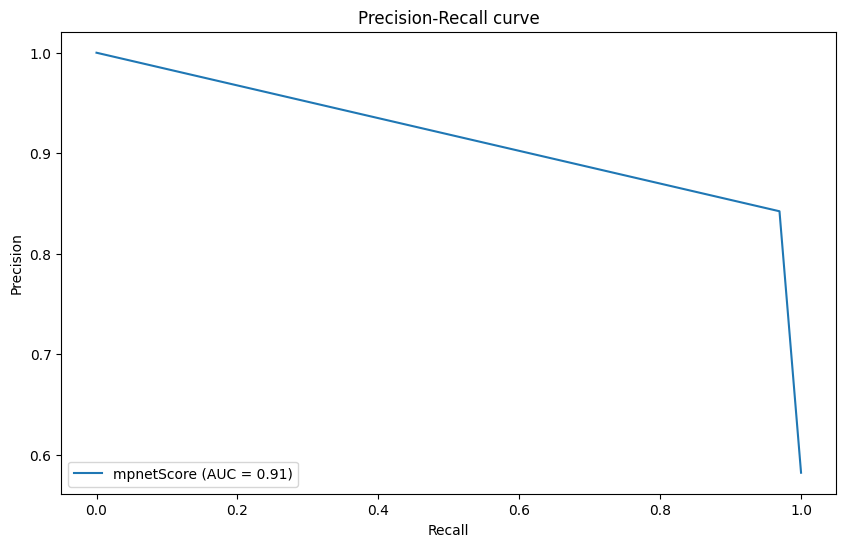

In [148]:
plt.figure(figsize=(10,6))
plt.plot(recall_mpnet, precision_mpnet, label='mpnetScore (AUC = %0.2f)' % auc_pr_mpnet)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

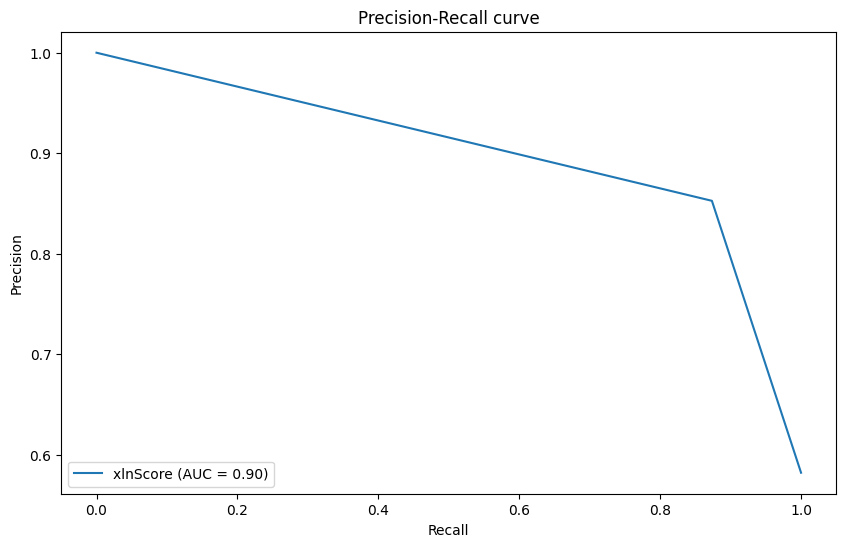

In [149]:
plt.figure(figsize=(10,6))
plt.plot(recall_xlm, precision_xlm, label='xlnScore (AUC = %0.2f)' % auc_pr_xlm)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

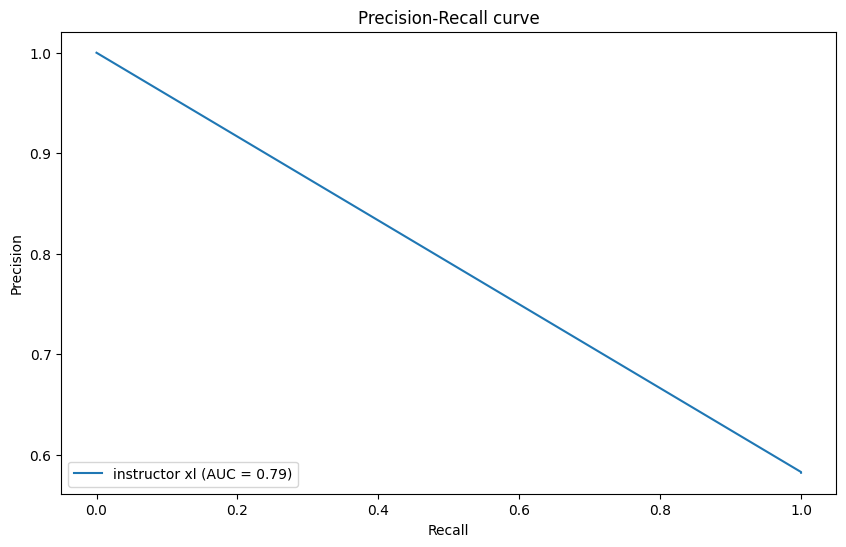

In [150]:
plt.figure(figsize=(10,6))
plt.plot(recall_xl, precision_xl, label='instructor xl (AUC = %0.2f)' % auc_pr_xl)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

## Tiempo de ejecucion

In [151]:
eval[['time_mpnet', 'time_xlm', 'time_instructor_xl']].describe()

,time_mpnet,time_xlm,time_instructor_xl
count,842.000000,842.000000,842.000000
mean,0.048009,0.051319,1.752996
std,0.010273,0.010527,0.325075
min,0.027785,0.033987,1.061810
25%,0.041189,0.043647,1.534130
50%,0.045862,0.049186,1.701457
75%,0.052995,0.056260,1.892221
max,0.094137,0.094640,3.176600


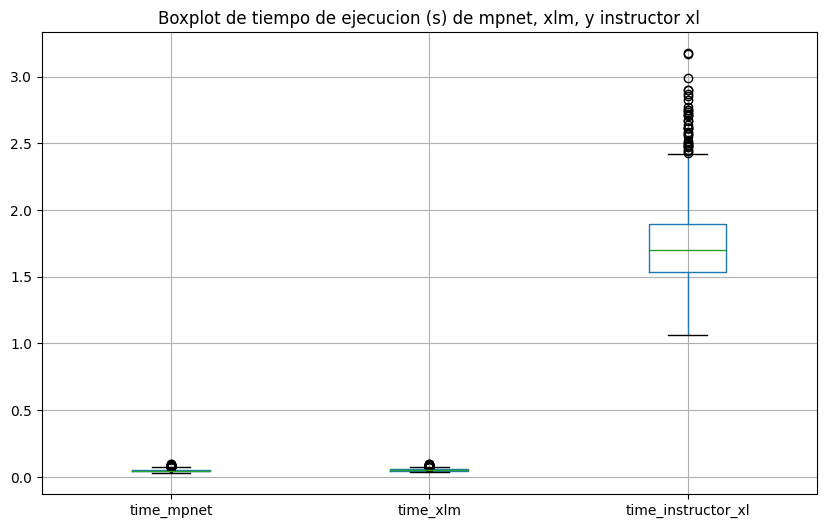

In [152]:
plt.figure(figsize=(10,6))
eval[['time_mpnet', 'time_xlm', 'time_instructor_xl']].boxplot()
plt.title('Boxplot de tiempo de ejecucion (s) de mpnet, xlm, y instructor xl')
plt.show()

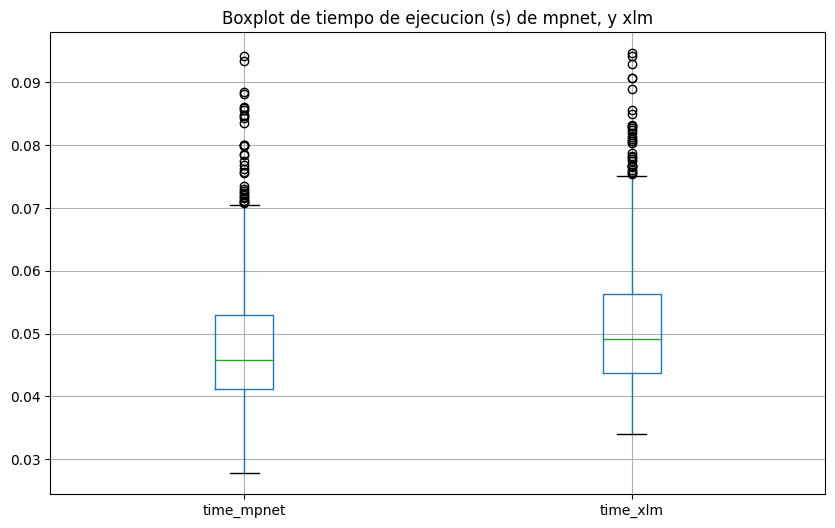

In [153]:
plt.figure(figsize=(10,6))
eval[['time_mpnet', 'time_xlm']].boxplot()
plt.title('Boxplot de tiempo de ejecucion (s) de mpnet, y xlm')
plt.show()

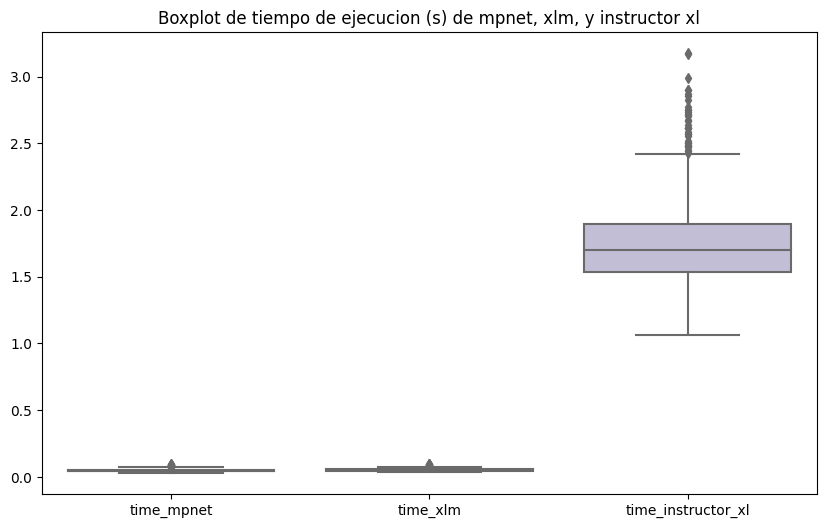

In [154]:
plt.figure(figsize=(10,6))
sns.boxplot(data=eval[['time_mpnet', 'time_xlm', 'time_instructor_xl']], palette='Set3')
plt.title('Boxplot de tiempo de ejecucion (s) de mpnet, xlm, y instructor xl')
plt.show()

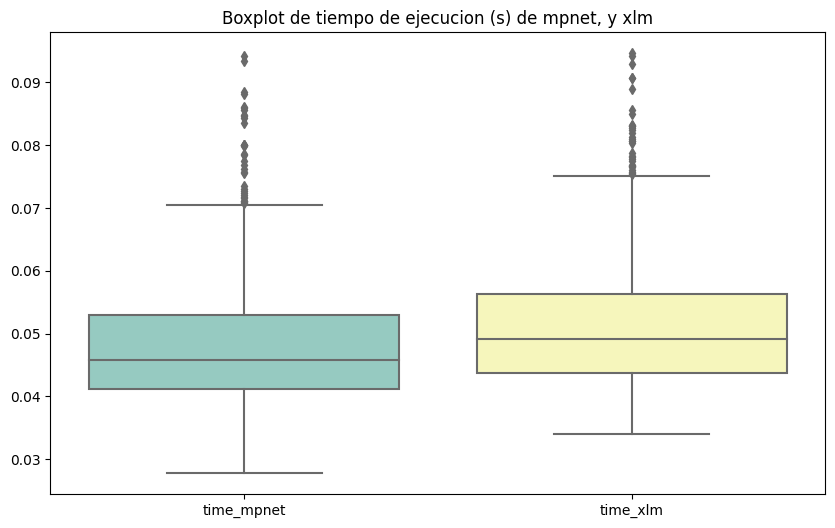

In [155]:
plt.figure(figsize=(10,6))
sns.boxplot(data=eval[['time_mpnet', 'time_xlm']], palette='Set3')
plt.title('Boxplot de tiempo de ejecucion (s) de mpnet, y xlm')
plt.show()

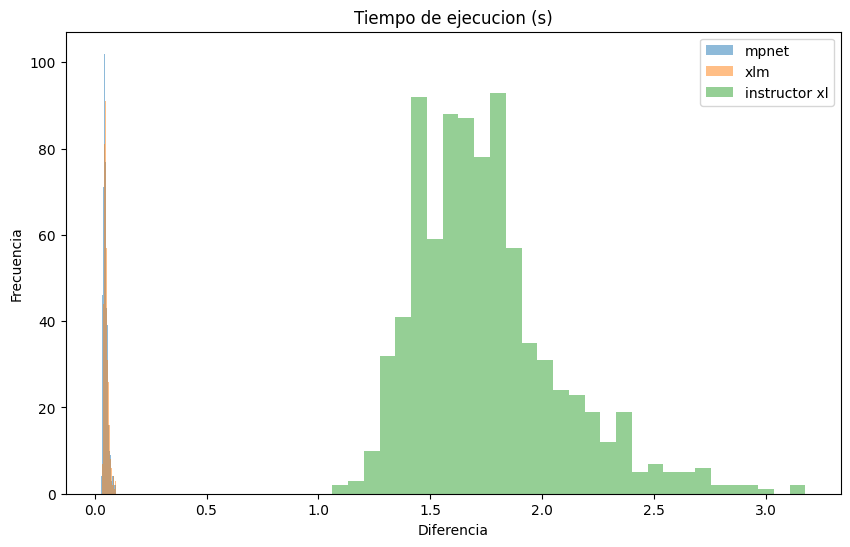

In [156]:
plt.figure(figsize=(10,6))

plt.hist(eval['time_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.hist(eval['time_xlm'], bins=30, alpha=0.5, label='xlm')
plt.hist(eval['time_instructor_xl'], bins=30, alpha=0.5, label='instructor xl')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Tiempo de ejecucion (s)')
plt.show()

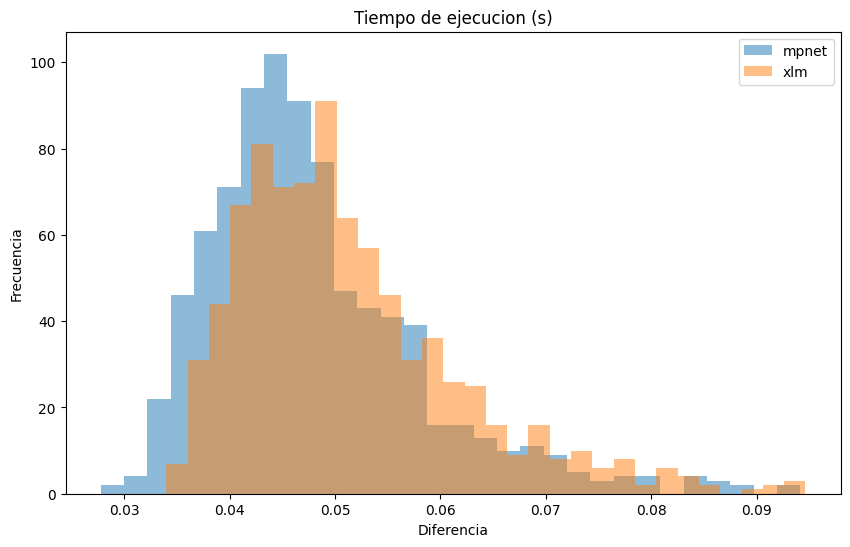

In [157]:
plt.figure(figsize=(10,6))

plt.hist(eval['time_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.hist(eval['time_xlm'], bins=30, alpha=0.5, label='xlm')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Tiempo de ejecucion (s)')
plt.show()

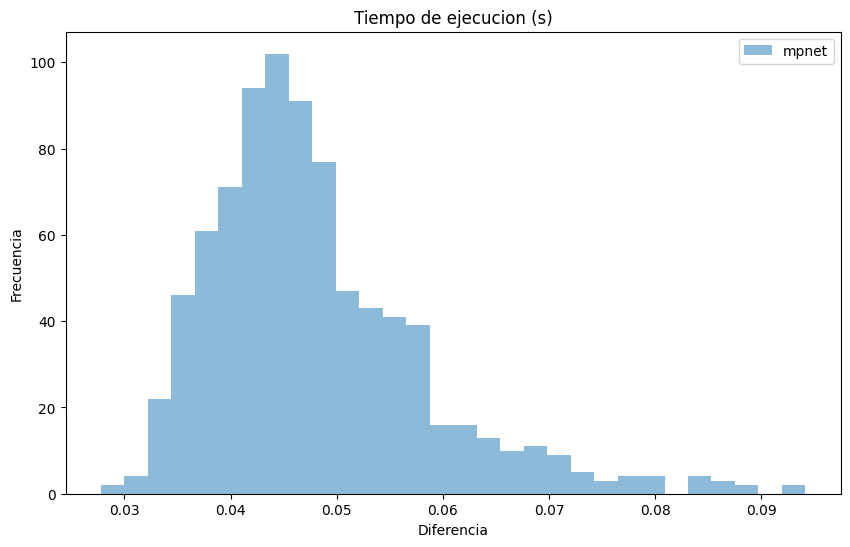

In [158]:
plt.figure(figsize=(10,6))

plt.hist(eval['time_mpnet'], bins=30, alpha=0.5, label='mpnet')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Tiempo de ejecucion (s)')
plt.show()

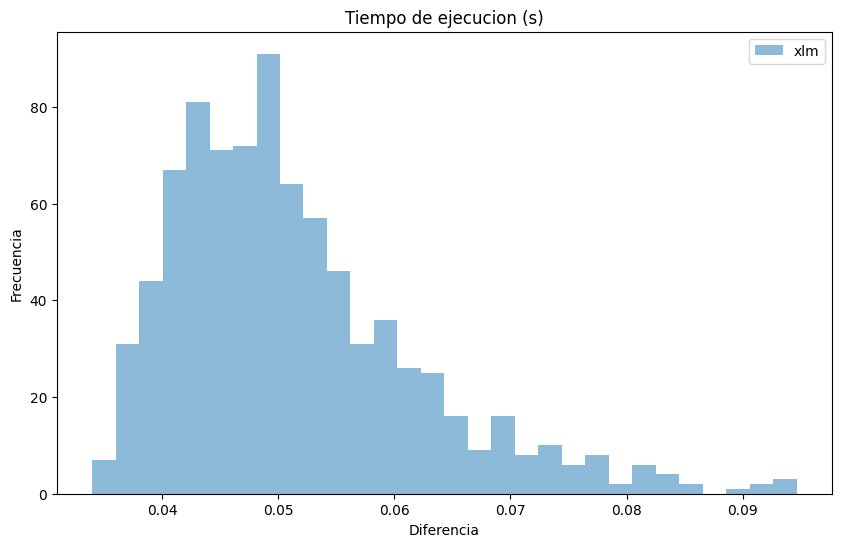

In [159]:
plt.figure(figsize=(10,6))

plt.hist(eval['time_xlm'], bins=30, alpha=0.5, label='xlm')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Tiempo de ejecucion (s)')
plt.show()

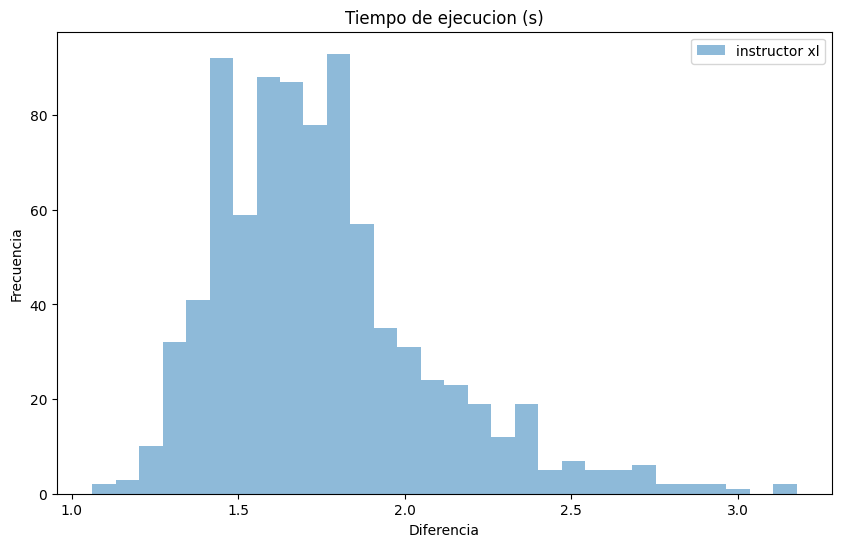

In [160]:
plt.figure(figsize=(10,6))

plt.hist(eval['time_instructor_xl'], bins=30, alpha=0.5, label='instructor xl')
plt.legend(loc='upper right')
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('Tiempo de ejecucion (s)')
plt.show()